**PROJECT 3**


**ЦЕЛЬ:**
Исследовать поведение пользователей в обновлённом приложении.


**ГИПОТЕЗЫ:**
1.	Обучение может влиять на скорость прохождения других этапов игры. 
2.	Возможно, повторное прохождение обучения положительно влияет на оплату.
3.	Есть ли вероятность того, что пользователь будет проходить обучение после выбора сложности?


**ЗАДАЧИ:**
1. Определить, насколько обучение сокращает время прохождения этапов игры.
2. Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.
3. Определить, насколько прозрачен процесс взаимодействия с игрой.


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Импортируем данные
events = pd.read_csv('data/7_4_Events (project).csv', sep=',')
events_df = events.copy()
purchase = pd.read_csv('data/7_4_Purchase (project).csv', sep=',')
purchase_df = purchase.copy()

# Делаем предобработку данных
purchase_df['event_type'] = 'purchase'
events_df = events_df.rename(columns={'id':'event_id'})
purchase_df = purchase_df.rename(columns={'id':'purchase_id', 'event_datetime':'start_time'})

# Фильтруем данные
mask1 = events_df['event_type'] == 'registration'
mask2 = events_df['start_time'] < '2019-01-01'
mask3 = events_df['start_time'] >= '2018-01-01'
list_of_registrations = events_df[mask1&mask2&mask3]['user_id'].unique()
events_df = events_df[events_df['user_id'].isin(list_of_registrations)]
purchase_df = purchase_df[purchase_df['user_id'].isin(list_of_registrations)]

# Объединяем данные
total_df = pd.concat([events_df, purchase_df], sort=False)
total_df = total_df.reset_index(drop=True).sort_values('start_time')
total_df['start_time'] = pd.to_datetime(total_df['start_time'])
display(total_df.head())
display(total_df.info())

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Index: 68559 entries, 0 to 68558
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   event_id        66959 non-null  float64       
 1   event_type      68559 non-null  object        
 2   selected_level  8342 non-null   object        
 3   start_time      68559 non-null  datetime64[ns]
 4   tutorial_id     32954 non-null  float64       
 5   user_id         68559 non-null  int64         
 6   purchase_id     1600 non-null   float64       
 7   amount          1600 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 4.7+ MB


None

**Гипотеза 1**

Распределяем пользователей на группы в зависимости от прохождения/не прохождения обучения

In [21]:
registration_df = total_df[total_df['event_type'] == 'registration']
list_of_registered_users = registration_df['user_id'].unique()
set_of_registered_users = set(list_of_registered_users)

tutorial_start_df = total_df[total_df['event_type'] == 'tutorial_start']
list_of_start_tut_users = tutorial_start_df['user_id'].unique()
set_list_of_start_tut_users = set(list_of_start_tut_users)

# Находим пользователей, завершивших обучение
tutorial_finish_df = total_df[total_df['event_type'] == 'tutorial_finish']
list_of_finished_tut_users = tutorial_finish_df['user_id'].unique()

# Находим начавших, но не завершивших обучение пользователей
started_not_finished_tut_users = set_list_of_start_tut_users.difference(set(list_of_finished_tut_users))

# Находим пользователей, не проходивших обучения
no_tutorials_users_set = set_of_registered_users.difference(set(list_of_start_tut_users))

# Пишем формулу для добавления нового признака (статус обучения) в таблицу
def group_name(id):
    if id in started_not_finished_tut_users:
        return 'started, but not finished'
    elif id in list_of_finished_tut_users:
        return 'finished'
    elif id in no_tutorials_users_set:
        return 'not started'
    
total_df['tutorial_status'] = total_df['user_id'].apply(group_name)
display(total_df.groupby('tutorial_status')['event_type'].value_counts())

                                                            

tutorial_status            event_type     
finished                   tutorial_start     16387
                           tutorial_finish    14904
                           registration       10250
                           level_choice        7501
                           pack_choice         5176
                           purchase            1447
not started                registration        8068
                           level_choice          98
                           pack_choice           74
                           purchase              22
started, but not finished  tutorial_start      1663
                           registration        1608
                           level_choice         743
                           pack_choice          487
                           purchase             131
Name: count, dtype: int64

Находим разницу во времени между различными этапами игры для выделенных трех групп пользователей.

In [22]:
# Создаем сводную таблицу, в которой отображаем все шаги и их время в игре для каждого пользователя
pivot_table1 = total_df.pivot_table(index=['user_id', 'tutorial_status'], columns='event_type', values='start_time', aggfunc='min').reset_index()
pivot_table1['level-registration'] = pivot_table1['level_choice'] - pivot_table1['registration']
pivot_table1['pack-level'] = pivot_table1['pack_choice'] - pivot_table1['level_choice']
pivot_table1['purchase-pack'] = pivot_table1['purchase'] - pivot_table1['pack_choice']
pivot_table1['tut_start-registration'] = pivot_table1['tutorial_start'] - pivot_table1['registration']
pivot_table1['tut_finish-tut_start'] = pivot_table1['tutorial_finish'] - pivot_table1['tutorial_start']
pivot_table1['level-tut_finish'] = pivot_table1['level_choice'] - pivot_table1['tutorial_finish']
pivot_table1['purchase-registration'] = pivot_table1['purchase'] - pivot_table1['registration']

# Выводим таблицу со средней разницей во времени между этапами игры для трех групп пользователей
pivot_table1_mean = pivot_table1.groupby('tutorial_status')[['purchase-registration', 'level-registration', 'tut_start-registration', 'tut_finish-tut_start', 'level-tut_finish', 'pack-level', 'purchase-pack']].mean()
display(pivot_table1_mean)


event_type,purchase-registration,level-registration,tut_start-registration,tut_finish-tut_start,level-tut_finish,pack-level,purchase-pack
tutorial_status,,,,,,,
finished,4 days 00:30:03.247408431,0 days 07:05:36.854819357,0 days 04:31:04.938146341,0 days 00:12:13.823121951,0 days 02:19:46.959472070,0 days 00:05:18.146058732,3 days 17:17:59.641326883
not started,4 days 09:06:01.909090909,0 days 05:15:33.122448979,NaT,NaT,NaT,0 days 00:05:23.824324324,4 days 04:49:33.590909090
"started, but not finished",4 days 05:32:53.213740458,0 days 08:12:57.551816958,0 days 05:25:02.892412935,NaT,NaT,0 days 00:05:05.295687885,3 days 21:14:46.908396946


In [23]:
# Делаем преобразование времени, чтобы построить диаграммы
pivot_table1['level-registration'] = (pivot_table1['level_choice'] - pivot_table1['registration']) / pd.Timedelta('1 hour')
pivot_table1['pack-level'] = (pivot_table1['pack_choice'] - pivot_table1['level_choice']) /  pd.Timedelta('1 minute')
pivot_table1['purchase-registration'] = (pivot_table1['purchase'] - pivot_table1['registration']) / pd.Timedelta('1 day')
pivot_table1['purchase-pack'] = (pivot_table1['purchase'] - pivot_table1['pack_choice']) / pd.Timedelta('1 day')
pivot_table1_mean = pivot_table1.groupby('tutorial_status')[['purchase-registration', 'level-registration', 'tut_start-registration', 'tut_finish-tut_start', 'level-tut_finish', 'pack-level', 'purchase-pack']].mean()

Строим столбчатые диаграммы.

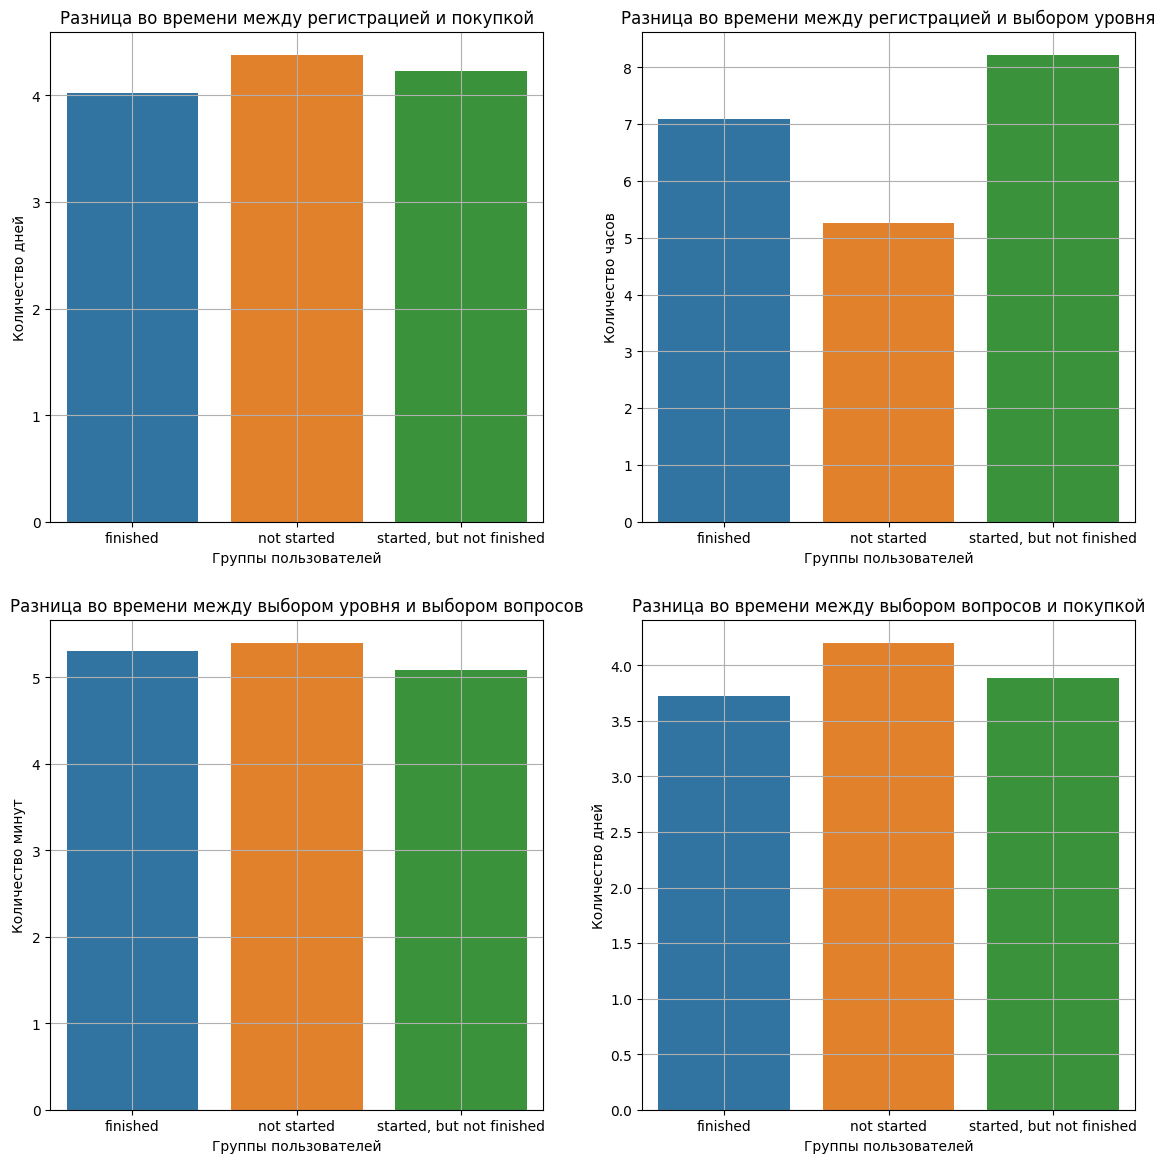

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(14, 14))

sns.barplot(ax=axes[0, 0], data=pivot_table1_mean, x=pivot_table1_mean.index, y='purchase-registration')
axes[0, 0].set_title('Разница во времени между регистрацией и покупкой')
axes[0, 0].set_ylabel('Количество дней')
axes[0, 0].set_xlabel('Группы пользователей')
axes[0, 0].grid()

sns.barplot(ax=axes[0, 1], data=pivot_table1_mean, x=pivot_table1_mean.index, y='level-registration')
axes[0, 1].set_title('Разница во времени между регистрацией и выбором уровня')
axes[0, 1].set_ylabel('Количество часов')
axes[0, 1].set_xlabel('Группы пользователей')
axes[0, 1].grid()

sns.barplot(ax=axes[1, 0], data=pivot_table1_mean, x=pivot_table1_mean.index, y='pack-level')
axes[1, 0].set_title('Разница во времени между выбором уровня и выбором вопросов')
axes[1, 0].set_ylabel('Количество минут')
axes[1, 0].set_xlabel('Группы пользователей')
axes[1, 0].grid()

sns.barplot(ax=axes[1, 1], data=pivot_table1_mean, x=pivot_table1_mean.index, y='purchase-pack')
axes[1, 1].set_title('Разница во времени между выбором вопросов и покупкой')
axes[1, 1].set_ylabel('Количество дней')
axes[1, 1].set_xlabel('Группы пользователей')
axes[1, 1].grid()


**Гипотеза 2**

In [25]:
# Создаем сводную таблицу, выводим количество регистраций, покупок и конверсию в зависимости от числа обучений
pivot_table2 = total_df.pivot_table(index='user_id', columns='event_type', values='start_time', aggfunc='count', fill_value=0).reset_index()
tutorial_start = pivot_table2.groupby(['tutorial_start'])[['registration', 'purchase']].agg('sum')
df_tutorial_start = pd.DataFrame(tutorial_start).reset_index().sort_values(by='tutorial_start', ascending=True)
df_tutorial_start['CR_start'] = round(df_tutorial_start['purchase'] / df_tutorial_start['registration'] * 100, 2)
display(df_tutorial_start)

event_type,tutorial_start,registration,purchase,CR_start
0,0,8068,22,0.27
1,1,9103,1207,13.26
2,2,1589,218,13.72
3,3,427,51,11.94
4,4,221,30,13.57
5,5,109,16,14.68
6,6,116,14,12.07
7,7,94,12,12.77
8,8,86,13,15.12
9,9,113,17,15.04


Строим столбчатую диаграмму

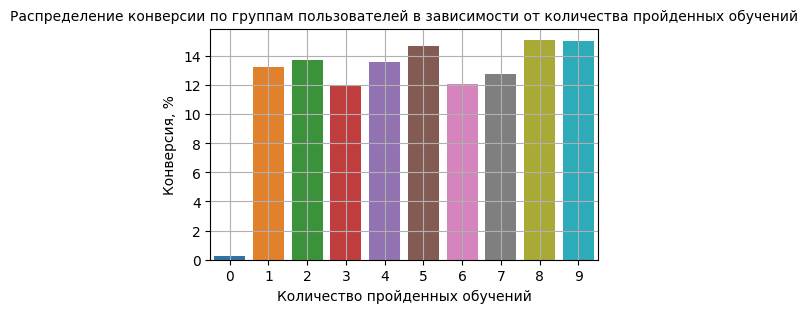

In [26]:
fig2 = plt.figure(figsize=(5, 3))
barplot2 = sns.barplot(data=df_tutorial_start, x='tutorial_start', y='CR_start')
barplot2.set_title('Распределение конверсии по группам пользователей в зависимости от количества пройденных обучений', fontsize=10)
barplot2.set_xlabel('Количество пройденных обучений')
barplot2.set_ylabel('Конверсия, %')
barplot2.grid()

Как видно из данных выше, конверсия в покупку не зависит от количества прохождений обучений, в среднем держится в районе 13.57%. 

In [27]:
# Расчет средней конверсии

tutorials = [13.26, 13.72, 11.94, 13.57, 14.68, 12.07, 12.77, 15.12, 15.04]
summa = 0
for i in tutorials:
    summa += i
    
print(round(summa/len(tutorials), 2))   


13.57


Строим круговую диаграмму

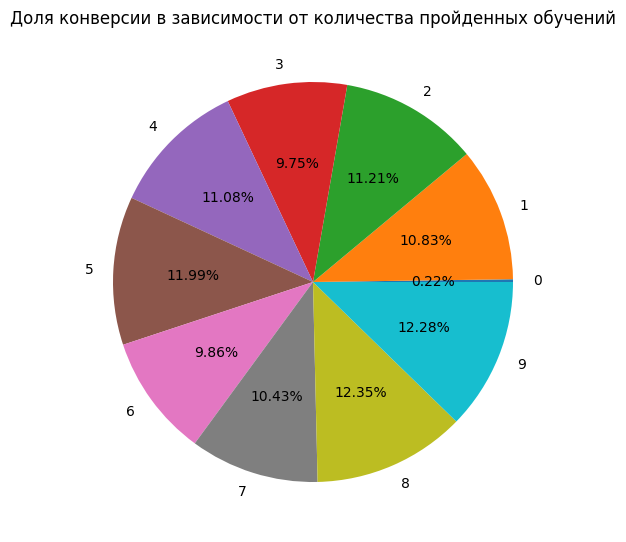

In [28]:
df_tutorial_start1 = df_tutorial_start['CR_start']

fig3 = plt.figure(figsize=(5, 5))
axes3 = fig3.add_axes([0, 0, 1, 1])
axes3.pie(
    df_tutorial_start1,
    labels=df_tutorial_start1.index,
    autopct='%.2f%%'
)
axes3.set_title('Доля конверсии в зависимости от количества пройденных обучений');

In [29]:
# Выводим суммы покупок и их процент в зависимости от числа обучений
pivot_table2_1 = total_df.pivot_table(index='user_id', columns='event_type', values='start_time', aggfunc='count', fill_value=0).reset_index()
pivot_table2_1 = pivot_table2_1[['user_id', 'tutorial_start']]
total_df_merged = total_df.merge(pivot_table2_1, how='left', on='user_id')

amount_per_tutorial = total_df_merged.groupby('tutorial_start')['amount'].sum()
amount_per_tutorial_list = list(amount_per_tutorial)
total_amount = total_df['amount'].sum()
amount_percent_per_tutorial = round(total_df_merged.groupby('tutorial_start')['amount'].sum()/total_amount*100, 2)
amount_percent_per_tutorial_list = list(amount_percent_per_tutorial)
amount_per_tutorial_df = pd.DataFrame({'amount_per_tutorial':amount_per_tutorial_list, 'amount_percent_per_tutorial': amount_percent_per_tutorial_list})
display(amount_per_tutorial_df)

,amount_per_tutorial,amount_percent_per_tutorial
0,2825.0,1.59
1,132475.0,74.77
2,24950.0,14.08
3,5675.0,3.20
4,2950.0,1.67
5,1950.0,1.10
6,1675.0,0.95
7,1325.0,0.75
8,1350.0,0.76
9,2000.0,1.13


Строим линейный график

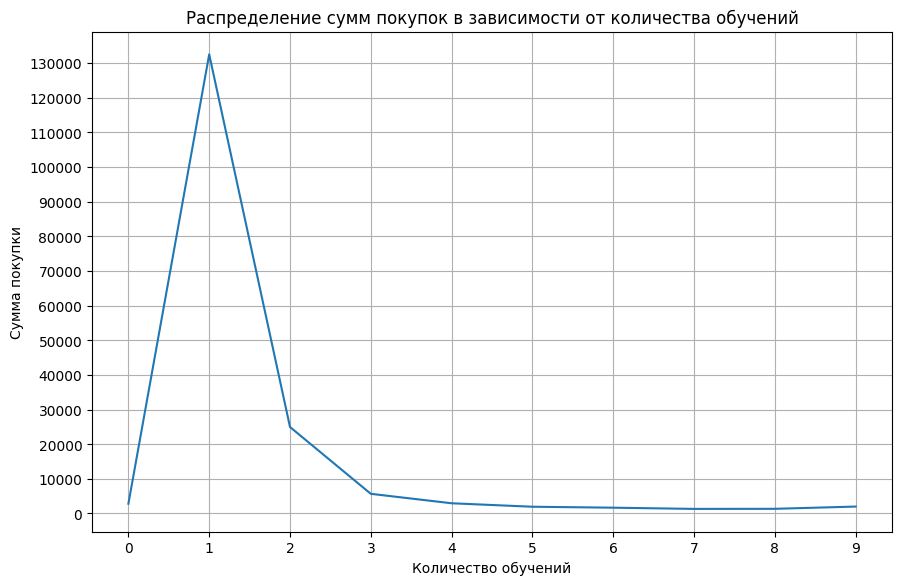

In [30]:
fig4 = plt.figure(figsize=(8, 5))
axes4 = fig4.add_axes([0, 0, 1, 1])
axes4.plot(amount_per_tutorial)
axes4.set_title('Распределение сумм покупок в зависимости от количества обучений')
axes4.set_xticks(range(0, 10, 1))
axes4.set_yticks(range(0, 140000, 10000))
axes4.set_xlabel('Количество обучений')
axes4.set_ylabel('Сумма покупки')
axes4.grid()

**Гипотеза 3**

Распределяем пользователей на группы в зависимости от времени прохождения обучения относительно выбора уровня.

In [31]:
# Считаем количество пользователей, выбравших уровень сложности
level_choice_user_qty = total_df[total_df['event_type'] == 'level_choice']['user_id'].nunique()
level_choice_user_list = total_df[total_df['event_type'] == 'level_choice']['user_id'].unique()

level_choice_df = total_df[total_df['user_id'].isin(level_choice_user_list)]
level_choice_df1 = level_choice_df.groupby('user_id')['event_type'].apply(tuple).reset_index()

# Выводим наиболее популярные пути прохождения игры среди пользователей, выбравших уровень
level_choice_df1['event_path'] = level_choice_df1['event_type'].apply(lambda x: ' > '.join(x))
level_choice_df1 = level_choice_df1[level_choice_df1['event_path'].str.contains('tutorial_start')]
table  = level_choice_df1.groupby('event_path')['user_id'].count().sort_values(ascending=False)
display(table.head(10))

event_path
registration > tutorial_start > tutorial_finish > level_choice > pack_choice                                                  2796
registration > tutorial_start > tutorial_finish > level_choice                                                                1713
registration > tutorial_start > tutorial_finish > level_choice > pack_choice > purchase                                       1083
registration > tutorial_start > level_choice > pack_choice                                                                     346
registration > tutorial_start > level_choice                                                                                   243
registration > tutorial_start > tutorial_finish > level_choice > pack_choice > tutorial_start > tutorial_finish                236
registration > tutorial_start > tutorial_finish > level_choice > tutorial_start > tutorial_finish                              169
registration > tutorial_start > tutorial_finish > tutorial_start > tutor

In [32]:
# Создаем сводную таблицу
pivot_table3 = level_choice_df.pivot_table(index=['user_id'], columns=['event_type'], values='start_time', aggfunc='max').reset_index()

# Находим разницу во времени между этапом начала обучения и выбором уровня
pivot_table3['time_delta'] = pivot_table3['level_choice'] - pivot_table3['tutorial_start'] 

# Находим количество пользователей, проходивших обучение после выбора уровня
tut_after_level_user_qty = pivot_table3[pivot_table3['time_delta'] < '1 seconds']['user_id'].nunique()

# Находим количество пользователей, проходивших обучение перед выбором уровня
level_after_tut_user_qty = pivot_table3[pivot_table3['time_delta'] > '1 seconds']['user_id'].nunique()

display(pivot_table3[['user_id', 'tutorial_start', 'level_choice', 'time_delta']].head())

event_type,user_id,tutorial_start,level_choice,time_delta
0,27835,2018-01-01 15:00:51,2018-01-01 20:37:22,0 days 05:36:31
1,27839,2018-01-01 19:11:36,2018-01-01 22:37:50,0 days 03:26:14
2,27840,2018-01-02 02:07:07,2018-01-02 05:18:42,0 days 03:11:35
3,27842,2018-01-02 18:08:01,2018-01-02 08:46:03,-1 days +14:38:02
4,27843,2018-01-02 13:34:51,2018-01-02 14:09:58,0 days 00:35:07


In [33]:
# Печатаем данные о группах пользователей в зависимости от времени прохождения обучения относительно выбора уровня
print('Количество всех пользователей, выбравших уровень сложности: ', level_choice_user_qty)
print('Количество пользователей, проходивших обучение после выбора уровней: ', tut_after_level_user_qty)
print('Количество пользователей, проходивших обучение до выбора уровней: ', level_after_tut_user_qty)
print()
percent_of_tut_after_lev_choice = tut_after_level_user_qty / level_choice_user_qty
percent_of_lev_choice_after_tut = level_after_tut_user_qty / level_choice_user_qty
print('Процент пользователей, проходивших обучение после выбора уровней сложности от всех пользователей, выбравших уровень сложности: {:.2%}'.format(percent_of_tut_after_lev_choice))
print('Процент пользователей, проходивших обучение до выбора уровней сложности от всех пользователей, выбравших уровень сложности: {:.2%}'.format(percent_of_lev_choice_after_tut))

Количество всех пользователей, выбравших уровень сложности:  8342
Количество пользователей, проходивших обучение после выбора уровней:  1386
Количество пользователей, проходивших обучение до выбора уровней:  6858

Процент пользователей, проходивших обучение после выбора уровней сложности от всех пользователей, выбравших уровень сложности: 16.61%
Процент пользователей, проходивших обучение до выбора уровней сложности от всех пользователей, выбравших уровень сложности: 82.21%


In [36]:
# Пишем функцию, чтобы добавить новый признак (обучение до/после выбора уровня/отсутствует) в таблицу
def tutorial_time(time):
    if time < pd.Timedelta('1 second'):
        return 'tutorial after level choice'
    elif time > pd.Timedelta('1 second'):
        return 'tutorial before level choice' 
    elif time is None:
        pass
    
    
pivot_table3['tutorial_time'] = pivot_table3['time_delta'].apply(tutorial_time)
pivot_table3['tutorial_time'] = pivot_table3['tutorial_time'].fillna('no tutorial')
pivot_table3_1 = pivot_table3.groupby('tutorial_time')['tutorial_time'].count()

Строим круговую диаграмму

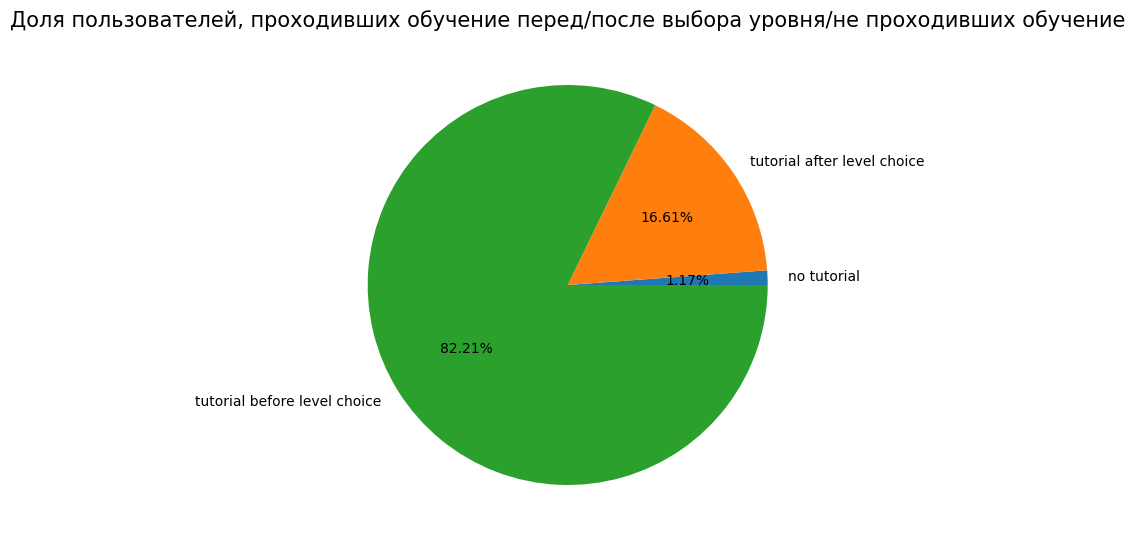

In [37]:
fig5 = plt.figure(figsize=(5, 5))
axes5 = fig5.add_axes([0, 0, 1, 1])
axes5.pie(
    pivot_table3_1,
    labels=pivot_table3_1.index,
    autopct='%.2f%%'
)
axes5.set_title('Доля пользователей, проходивших обучение перед/после выбора уровня/не проходивших обучение', fontsize=15);

**ИТОГОВЫЕ ВЫВОДЫ:**

1. Несмотря на то, что группа пользователей, не проходящих обучение, после регистрации в среднем на 2 часа раньше приступает к выбору уровня сложности, чем группа пользователей, закончивших обучение, в целом это никак не влияет на их скорость покупок. Наоборот, пользователи, завершившие обучение, в среднем совершают покупки быстрее, чем другие пользователи. Те, кто завершают обучение, проходят его примерно за 12 минут. Можно утверждать, что этап обучения замедляет лишь этап выбора уровня сложноси и никак не влияет на этап выпора бесплатного пакета вопросов, немного ускоряет покупки после выбора бесплатного пакета вопросов. На мой взгляд, по первой гипотезе можно сделать вывод: влияние этапа обучения на скорость прохождения других этапов игры есть, но оно незначительно.

2. По второй гипотезе можно сделать вывод: количество повторных прохождений обучения не влияет на покупки. Конверсия в покупку не зависит от количества прохождений обучений, в среднем держится в районе 13.57%. На графике отчетливо видно, что большая часть оплат (всего 1207) приходится на группу пользователей, прошедших 1 обучение. Эта группа тратит деньги на сумму 132475.0, что составляет 74.77 % от суммы всех оплат. Повторные обучения приносят значительно меньше дохода.

3. По третьей гипотеле можно сделать вывод: процент пользователей, проходящих обучение после выбора уровня сложности составляет 16.61%, он достаточно небольшой (1386 человек). Также, если мы рассмотрим самые популярные пути поведения пользователей, выбиравших уровень сложности, можно увидеть, что пути с повторным обучением располагаются на 6, 7 и 10 местах по популярности. Большинство пользователей (82.21%) проходит обучение перед выбором уровня сложности и не возвращаются к нему впоследствии. Это говорит о том, что процесс взаимодействия с игрой достаточно прозрачен. Также есть 1.17% пользователей, которые выбрали уровень сложности, но не проходили обучение.